In [2]:
import numpy as np
import pandas as pd
import re
from pathlib import Path
import os
import sys
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects as rmv
import matplotlib.pyplot as plt
import seaborn as sns 
plt.close("all")


In [5]:
# --- Base directory and filename
base_dir = os.path.abspath("")
add_dir = ["2025_11_06_02","2025_11_06_03"] #! write "User/Documents" not "/User/Documents" 
folders = {}
for i,f in enumerate(add_dir):
    folder = Path(os.path.join(base_dir,f))
    folders[f"name{i}"] = folder
    print("folder being used:",folder,"\n")
print(folders)

folder being used: C:\Users\orodrigov\Desktop\Photon counting\2025_11_06_02 

folder being used: C:\Users\orodrigov\Desktop\Photon counting\2025_11_06_03 

{'name0': WindowsPath('C:/Users/orodrigov/Desktop/Photon counting/2025_11_06_02'), 'name1': WindowsPath('C:/Users/orodrigov/Desktop/Photon counting/2025_11_06_03')}


In [6]:
# --- Modifiable PARAMETERS
THRESHOLD = [106] # Maxminimum value for masking 
CONNECTIVITY = 1 # Number of neighbors necessary to include in one cluster
MIN_SIZE_CLUSTER = 9

In [7]:
## --- FUNCTIONS
# --- parsear nombre de archivo : 
# gn{gain}_n{fotograms}_t{exposure-time-in-sec}_gate_DDG_width{gate-width-in-sec}_{date}_{time-of-acquisition}.npz ---
# ex : gn1_n1_t0p2_gate_DDG_width5p00e-03_2025-10-07_15-40
def parse_fname(name):
    fname = os.path.basename(name)    # basename of '/foo/bar/item' returns 'item'
    # Pattern to match filenames like:
    # gn4095_n1_t0p001_gate_DDG_width1p00e-05_2025-10-27_17-38.npz
    pattern = (
        r"gn(\d+)_n(\d+)_t([\d\w\+\-]+)_gate_DDG_width([\d\w\+\-]+)_"  # gn, n, t, width
        r"([\d\-]+)_([\d\-]+)\.npz$"  # date, time
    )
    m = re.match(pattern, fname)
    if m:
        gain = int(m.group(1))
        npics = int(m.group(2))
        texp_s = float(m.group(3).replace("p", "."))
        gate_width_s = float(m.group(4).replace("p", "."))
        date = m.group(5)
        time = m.group(6)
    else:
        raise ValueError(f"Nombre no reconocido: {name}")
    print("gain",gain," npics",npics," texp_s",texp_s," gate_width_s",gate_width_s)    
    return gain,npics,texp_s,gate_width_s,date,time

In [8]:
# --- Function using label used for counting clusters
def count_clusters(img, thr, connectivity):
    mask = img > thr
    labeled = label(mask, connectivity=connectivity)
    counts = rmv(labeled, min_size=MIN_SIZE_CLUSTER)
    return counts.max()

In [9]:
# --- Reads file and collects its variables, then returns them as  
def process_file(npz_path, thr,connectivity):
# Get the measure's variables from the file's name
    gain,npics,texp_s,gate_width_s,date,time = parse_fname(npz_path.name)
# Load the data file as an array (N_frames, Px_hight, Px_length) 
    data = np.load(npz_path)["images"]  # #NpzFile (numpy.ndarray) (N, 600, 600) with keys: "images" 
                                        # This means that each data[i] is a 2D image
# Proceed to count cluster in data array ( in list comprehension : [count_clusters(data[i], thr, connectivity) for i in range(data.shape[0])] )
    counts = []
    for i in range(data.shape[0]):
        n_clusters = count_clusters(data[i], thr, connectivity)
        counts.append(n_clusters)
    
    # Some debbuging options
    if False: # Debbuging 'counts' and 'label' function    
        # np.asarray(counts) #Test of debugging counts SHOULD MAKE COUNTS INTO ITERATION FOR N FRAMES, BUT MAYBE TOO MUCH RAM USAGE
        # print("COUNTS:",counts, " type(COUNTS)",type(counts)) #Test of debugging counts
        # for test in counts: #Test of debugging counts
        #     print(type(test)) #Test of debugging counts
    # Debugging
        print("\n type(data):",type(data),"data.shape:",data.shape)
        print("\n",data.shape[0],"frames procesados de tamaño",data.shape,"data.dtype:",data.dtype)
        # print("counts:",counts," , n_clusters_mean:", float(np.mean(counts))," , n_clusters_std:",float(np.std(counts, ddof=1)),"\n")
        x=counts
        # print("what ddfof=0 does:",np.sqrt((((x-np.mean(x))**2)/len(x)).sum()))
        # print("what ddfof=1 does:", np.sqrt((((x-np.mean(x))**2)/(len(x)-1)).sum()))
        x=data
        # print("what ddfof=0 does:",np.sqrt((((x-np.mean(x))**2)/len(x)).sum()))
        # print("what ddfof=1 does:", np.sqrt((((x-np.mean(x))**2)/(len(x)-1)).sum()))
    
        # Return library with experiment's variables as keys
    return {
        "file": npz_path.name,
        "gain": gain,
        "npics": npics,
        "texp_s": texp_s,
        "gate_width_s": gate_width_s,
        "date": date+"_"+time,
        "threshold": thr, 
        "n_frames": data.shape[0], #old
        "n_clusters":counts,# Can't make it work yet. issue with "Name: n_clusters, dtype: object -> TypeError: float() argument must be a string or a number, not 'list'" and "ValueError: setting an array element with a sequence"
        "n_clusters_mean": float(np.mean(counts)), #old
        "n_clusters_std": float(np.std(counts, ddof=1)),#old #getting Nan as result #probably bcs nbr of frames was 1
    } 

In [10]:
# --- Processes all files and saves data to csv. Also has iteration over threshold values. Returns DataFrame for further in-file manipulation
def make_csv(connectivity,threshold,folder,out_csv = folder/"Data_roll_multi_files.csv",):
    rows = [] # Contains dictionnary : {'file','gain','npics','texp_s','gate_width_s', 'date','threshold','n_frames','n_clusters','n_clusters_mean''n_clusters_std'}
    files = sorted(folder.glob("*.npz")) # Finds all .npz files in folder and sorts them alphabetically 
    
    # --- Loop to process all files and save info into 'rows' (LIST)
    for thr in threshold:
        for f in files: # Loop over .npz files
            rows.append(process_file(f, thr,connectivity)) # Iterate over threshold
    # -- Convert 'rows' into a DataFrame
    df = pd.DataFrame(rows)
    
    if False: # Debugging
        print("\nrows dictionnary:\n",rows,"\n")
        print("DataFrame from make_csv fctº:\n",df)
        
    # --- Save DataFrame in .csv for future analysis
    df.to_csv(out_csv, index=False)
    print("CSV guardado en:", out_csv,"\n")
    return df    # To reuse it in same code without need of reloading csv file
df = make_csv(CONNECTIVITY,THRESHOLD,folders)

gain 4095  npics 1000  texp_s 0.0025  gate_width_s 5e-06
CSV guardado en: C:\Users\orodrigov\Desktop\Photon counting\2025_11_06_03\clusters_vs_power.csv 



In [47]:
len(df["n_clusters"][0])

1000

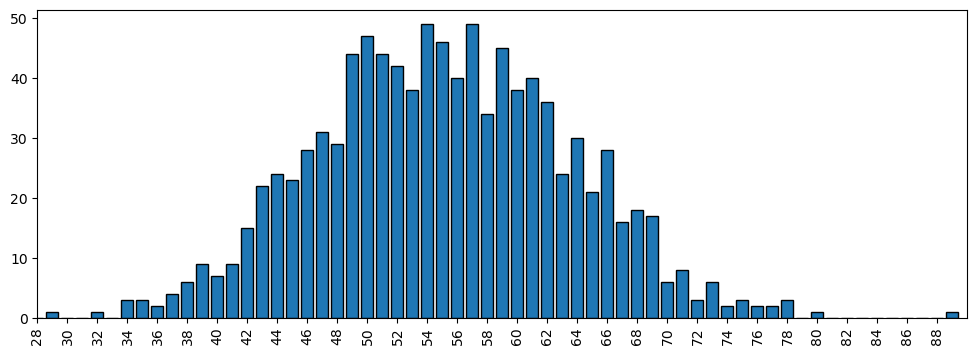

1000
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  0  0  1  0  3  3  2  4  6  9  7  9 15 22 24 23 28 31
 29 44 47 44 42 38 49 46 40 49 34 45 38 40 36 24 30 21 28 16 18 17  6  8
  3  6  2  3  2  2  3  0  1  0  0  0  0  0  0  0  0  1] (90,)


In [76]:
n_clusters = np.asarray(df["n_clusters"][0])


fig, ax = plt.subplots(figsize=(12, 4))
freq = np.bincount(n_clusters)
ax.bar(x=range(n_clusters.max()+1), height=freq, width=0.8, edgecolor="black", align="center")
ax.set(xticks = range(0,n_clusters.max()+1,2), 
       xlim=[n_clusters.min()-1, n_clusters.max()+1])
ax.tick_params(axis='x',rotation=90)
ax.set_xlabel("Gray Value")
ax.set_ylabel("Pixel Count in log")
plt.show()


np.unique(n_clusters)
print(freq.sum())
print(freq,freq.shape)
                                 

In [ ]:
#STOPPED HERE REDDID ALL PREVIOUS CODE, ADDED N_CLUSTER AND POSSIBILITY FOR LIST OF THRESHOLD VALUES AS WELL AS VARYING CONNECTIVITY
#  APPART FRM CONTINUING REVSNG THE PLOTS, CHECK ALSO HOW THE CSV FILE IS SAVED AND WHERE AND WIT WHICH NAME

def plot_exposure_vs_clusters(df,threshold,ax,fixed="gate_width_s"):

    for gate_width_s, g in df.groupby(fixed): #all rows that have the same "column_value" are grouped, g = a smaller DataFrame containing only those rows
        g = g.sort_values("texp_s") #ensure correct order for x-axis
        # print(g["texp_s"],"\n g clusters",g["n_clusters"].to_numpy())
        # print(g["texp_s"].dtypes,g["texp_s"].shape )
        # print(g["n_clusters"].dtypes,g["n_clusters"].shape, g["n_clusters_mean"].shape)
        # print(g["n_clusters"],"\n",g["n_clusters_mean"],"\n")
        # print("",g["n_clusters"].to_numpy())
        # print(g["n_clusters"].to_numpy()[1],":[1]  [1][3]:",g["n_clusters"].to_numpy()[1][3],"\n [0:][]",g["n_clusters"].to_numpy()[1][0:])
        if g["n_clusters"].dtypes == object: 
            ax.plot(g["texp_s"]*1e3,          # X-axis
                     g["n_clusters_mean"], # Y-axis                    
                     marker="o",      # draw circle markers connected by lines
                     label=f"{gate_width_s*1e6:.2f}"+r"$\mu s$"
                     )
        else:
            ax.errorbar(   g["texp_s"],      # X-axis
                            g["n_clusters"],  # Y-axis
                     yerr=g["n_clusters_std"],  # vertical error bars (standard deviation)
                     fmt="o-",      # draw circle markers connected by lines
                     capsize=3,     # size of little caps on the error bars
                     label=f"{gate_width_s} s"
                     )
    ax.set_xscale("linear") 
    ax.set_xlabel(r"Tiempo de exposición [ms]")
    ax.set_ylabel("Clusters promedio (±std) por frame")
    ax.set_title(f"exposure_vs_clusters")
    ax.grid(True, which="both", ls=":")
    ax.legend(loc="lower right",title="Tgate",draggable=True)
    

def plot_gate_vs_clusters(df,threshold,ax,fixed="texp_s"):
    #fig,ax =plt.figure(num=f"gate-width_vs_clusters thr:{threshold}",figsize=(7,5))
    for time_exposure, g in df.groupby(fixed): #all rows that have the same "column_value" are grouped, g = a smaller DataFrame containing only those rows
        g = g.sort_values("gate_width_s") #ensure correct order for x-axis
        if g["n_clusters"].dtypes == object:
            ax.plot(g["gate_width_s"]*1e6,
                     g["n_clusters_mean"],
                     marker="+",
                     label=f"{time_exposure*1e3:.2f}ms"
                     )
        else:
            ax.errorbar(g["gate_width_s"]*1e6, # X-axis
                     g["n_clusters_mean"],      # Y-axis
                     yerr=g["n_clusters_std"],  # vertical error bars (standard deviation)
                     fmt="+-",      # draw circle markers connected by lines
                     capsize=3,     # size of little caps on the error bars
                     label=f"Texposure={time_exposure:.2f} ms"
                     )
    ax.set_xscale("linear") 
    ax.set_xlabel(r"Gate width [$\mu s$]")
    ax.set_ylabel("Clusters promedio (±std) por frame")
    ax.set_title(f"gate-width_vs_clusters")
    ax.grid(True, which="both", ls=":")
    ax.legend(loc="lower right",title="Texposure",draggable=True)

def plot_clusters(df, group_var, x_var, y_var, subplot_var=None, threshold=None,figsize=(9,5)):
     # Handle subplots if requested
    if subplot_var:
        unique_vals = sorted(df[subplot_var].unique())
        n_subplots = len(unique_vals)
        fig, axes = plt.subplots(1, n_subplots, figsize=(figsize[0]*n_subplots/3, figsize[1]), sharey=True)
        if n_subplots == 1:
            axes = [axes]
    else:
        fig, axes = plt.subplots(1, 1, figsize=figsize)
        axes = [axes]
        unique_vals = [None]
        
        # Iterate over subplots
    for ax, val in zip(axes, unique_vals):
        if val is not None:
            sub_df = df[df[subplot_var] == val]
            title_suffix = f"{subplot_var} = {val}"
        else:
            sub_df = df
            title_suffix = ""

        # Group and plot each line
        for grp, g in sub_df.groupby(group_var):
            g = g.sort_values(x_var)
            ax.errorbar(
                g[x_var],
                g[y_var],
                yerr=g["n_clusters_std"],
                fmt="o-",
                capsize=3,
                label=f"{grp}"
            )

        ax.set_xscale("linear")
        ax.set_xlabel("")
        ax.set_ylabel("")
        title_main = f"Threshold = {threshold}" if threshold is not None else "Clusters vs Variables"
        ax.set_title(f"{title_main}\n{title_suffix}".strip())
        ax.grid(True, which="both", ls=":")

         # Get number of legend entries
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right',title=f"{group_var}",draggable=True)
        # if len(labels) > 3: #check how many legend entries there are and gets the legend box outside the plot if it's too big
        #     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        # else:
        #     ax.legend()
        fig.supxlabel(f"{x_var}")
        fig.supylabel("Clusters promedio (±std) por frame")
    plt.tight_layout()
    

# def exposure_vs_clusters(df):
#     fig,(ax1,ax2)=plt.subplot(1,2,figsize=(7,5),sharey=True)
#     for gate_width_s, g in df.groupby("gate_width_s"): #all rows that have the same "column_value" are grouped, g = a smaller DataFrame containing only those rows
#         g = g.sort_values("texp_s") #ensure correct order for x-axis
#         ax1.errorbar(g["texp_s"],           # X-axis
#                      g["n_clusters_mean"],  # Y-axis
#                      yerr=g["n_clusters_std"],  # vertical error bars (standard deviation)
#                      fmt="o-",      # draw circle markers connected by lines
#                      capsize=3,     # size of little caps on the error bars
#                      label=f"Tgate={gate_width_s} s"
#                      )
#     ax1.xscale("linear") 
#     ax1.set_xlabel("Tiempo de exposición [s]")
#     ax1.set_ylabel("Clusters promedio (±std) por frame")
#     ax1.title(f"Threshold = {THRESHOLD}")
#     plt.grid(True, which="both", ls=":")
#     plt.legend()
#     plt.show()

def plot_ratio_40_20(df,threshold):
    # dejar sólo potencias que tengan ambos tgate = 20 y 40 ns
    g20 = df[df["tgate_ns"] == 20].set_index("power_uW") #df[df["tgate_ns"] == 20] -> filters the DataFrame to include only rows where tgate_ns equals 20.
    g40 = df[df["tgate_ns"] == 40].set_index("power_uW") #.set_index("power_uW") -> makes the input power (power_uW) the index of this smaller DataFrame.
    common = g20.index.intersection(g40.index) #finds the common power values (the overlapping x-values) between both df.
    if len(common) == 0:
        print("No hay potencias en común entre 20ns y 40ns")
        return

    ratio = g40.loc[common, "n_clusters_mean"] / g20.loc[common, "n_clusters_mean"]

    plt.figure(figsize=(7,5))
    plt.plot(common, ratio, "o", label="Clusters 40ns / 20ns")
    plt.xlabel("Potencia de entrada [µW]")
    plt.ylabel("Cociente Clusters (40ns / 20ns)")
    plt.title(f"Threshold = {threshold}")
    plt.grid(True, ls=":")
    plt.legend()

def plot_cluster_histograms(df, group_var, x_var, subplot_var=None, threshold=None, figsize=(9,5), bins=20):
    """
    Plots histograms of n_clusters_mean (or any y_var) grouped by a categorical variable.
    """

    # Handle subplots if requested
    if subplot_var:
        unique_vals = sorted(df[subplot_var].unique())
        n_subplots = len(unique_vals)
        fig, axes = plt.subplots(1, n_subplots, figsize=(figsize[0]*n_subplots/3, figsize[1]), sharey=True)
        if n_subplots == 1:
            axes = [axes]
    else:
        fig, axes = plt.subplots(1, 1, figsize=figsize)
        axes = [axes]
        unique_vals = [None]

    # Iterate over subplots
    for ax, val in zip(axes, unique_vals):
        if val is not None:
            sub_df = df[df[subplot_var] == val]
            title_suffix = f"{subplot_var} = {val}"
        else:
            sub_df = df
            title_suffix = ""

        # Plot histograms for each group
        for grp, g in sub_df.groupby(group_var):
            sns.histplot(
                data=g,
                x=x_var,
                bins=bins,
                kde=True,
                label=f"{group_var}={grp}",
                ax=ax,
                alpha=0.5
            )

        title_main = f"Threshold = {threshold}" if threshold is not None else "Cluster Distribution"
        ax.set_title(f"{title_main}\n{title_suffix}".strip())
        ax.set_xlabel(x_var)
        ax.set_ylabel("Count")
        ax.grid(True, ls=":")
        
        ax.legend()

    fig.supylabel("Frequency")
    plt.tight_layout()

def plot_histograms(df,threshold, var="n_clusters_mean", group_var=None, bins=20, figsize=(8,5)):
    if var == "n_clusters_mean":
        min_val = int(np.floor(df[var].min()))
        max_val = int(np.ceil(df[var].max()))
        bins = np.arange(min_val, max_val + 1, 1)  # bins of 1 integer width

    fig,ax = plt.subplots(1,1,figsize=figsize)
    if group_var:
        unique_vals = sorted(df[group_var].unique())
        for val in unique_vals:
            sub_df = df[df[group_var] == val]
            ax.hist(
                sub_df[var],
                bins=bins,
                alpha=0.6,
                label=val
            )
        ax.legend(loc="lower right",title=f"{group_var}",draggable=True)
    else:
        ax.hist(df[var], bins=bins, color='skyblue', edgecolor='black', alpha=0.7)

    ax.set_xlabel(var)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Histogram of {var}" + (f" grouped by {group_var}" if group_var else ""))
    ax.grid(True, ls=":", alpha=0.6)

Procesando:   0%|                                                                                | 0/1 [00:00<?, ?it/s]

gain 4095  npics 1000  texp_s 0.0025  gate_width_s 5e-06



Procesando: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.98s/it]
C:\Users\orodrigov\AppData\Local\Temp\ipykernel_19248\346165530.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


CSV guardado en: C:\Users\orodrigov\Desktop\Photon counting\2025_11_06_03\cluster_vs_exposure-time.csv 



Procesando:   0%|                                                                                | 0/1 [00:00<?, ?it/s]

gain 4095  npics 1000  texp_s 0.0025  gate_width_s 5e-06



Procesando: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.05s/it]


CSV guardado en: C:\Users\orodrigov\Desktop\Photon counting\2025_11_06_03\cluster_vs_exposure-time.csv 



Procesando:   0%|                                                                                | 0/1 [00:00<?, ?it/s]

gain 4095  npics 1000  texp_s 0.0025  gate_width_s 5e-06



Procesando: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.01s/it]


CSV guardado en: C:\Users\orodrigov\Desktop\Photon counting\2025_11_06_03\cluster_vs_exposure-time.csv 



Procesando:   0%|                                                                                | 0/1 [00:00<?, ?it/s]

gain 4095  npics 1000  texp_s 0.0025  gate_width_s 5e-06



Procesando: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.36s/it]


CSV guardado en: C:\Users\orodrigov\Desktop\Photon counting\2025_11_06_03\cluster_vs_exposure-time.csv 



Procesando:   0%|                                                                                | 0/1 [00:00<?, ?it/s]

gain 4095  npics 1000  texp_s 0.0025  gate_width_s 5e-06



Procesando: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.77s/it]


CSV guardado en: C:\Users\orodrigov\Desktop\Photon counting\2025_11_06_03\cluster_vs_exposure-time.csv 



Procesando:   0%|                                                                                | 0/1 [00:00<?, ?it/s]

gain 4095  npics 1000  texp_s 0.0025  gate_width_s 5e-06



Procesando: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.90s/it]


CSV guardado en: C:\Users\orodrigov\Desktop\Photon counting\2025_11_06_03\cluster_vs_exposure-time.csv 



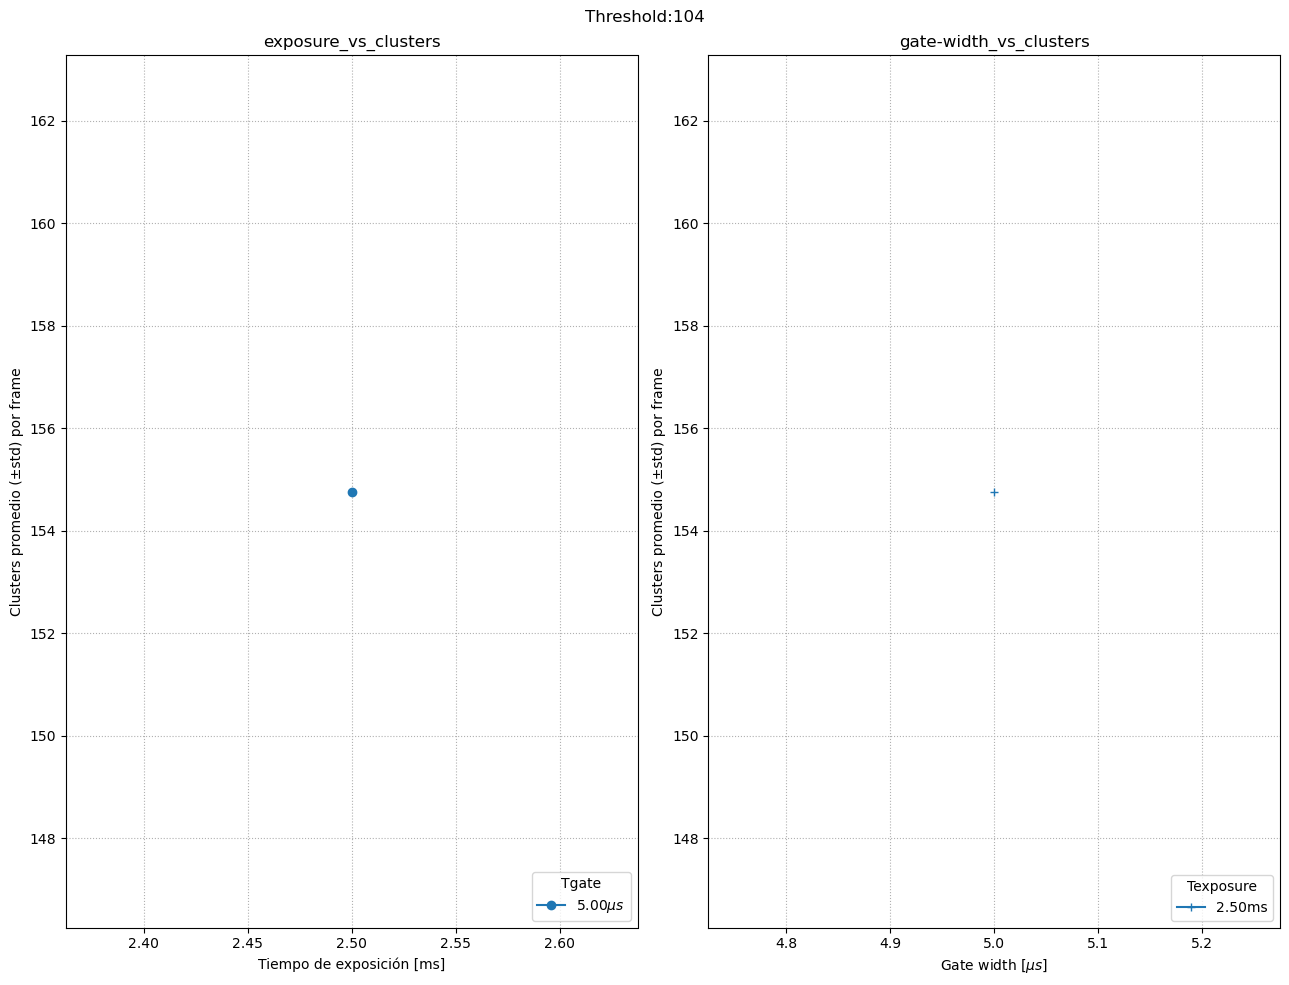

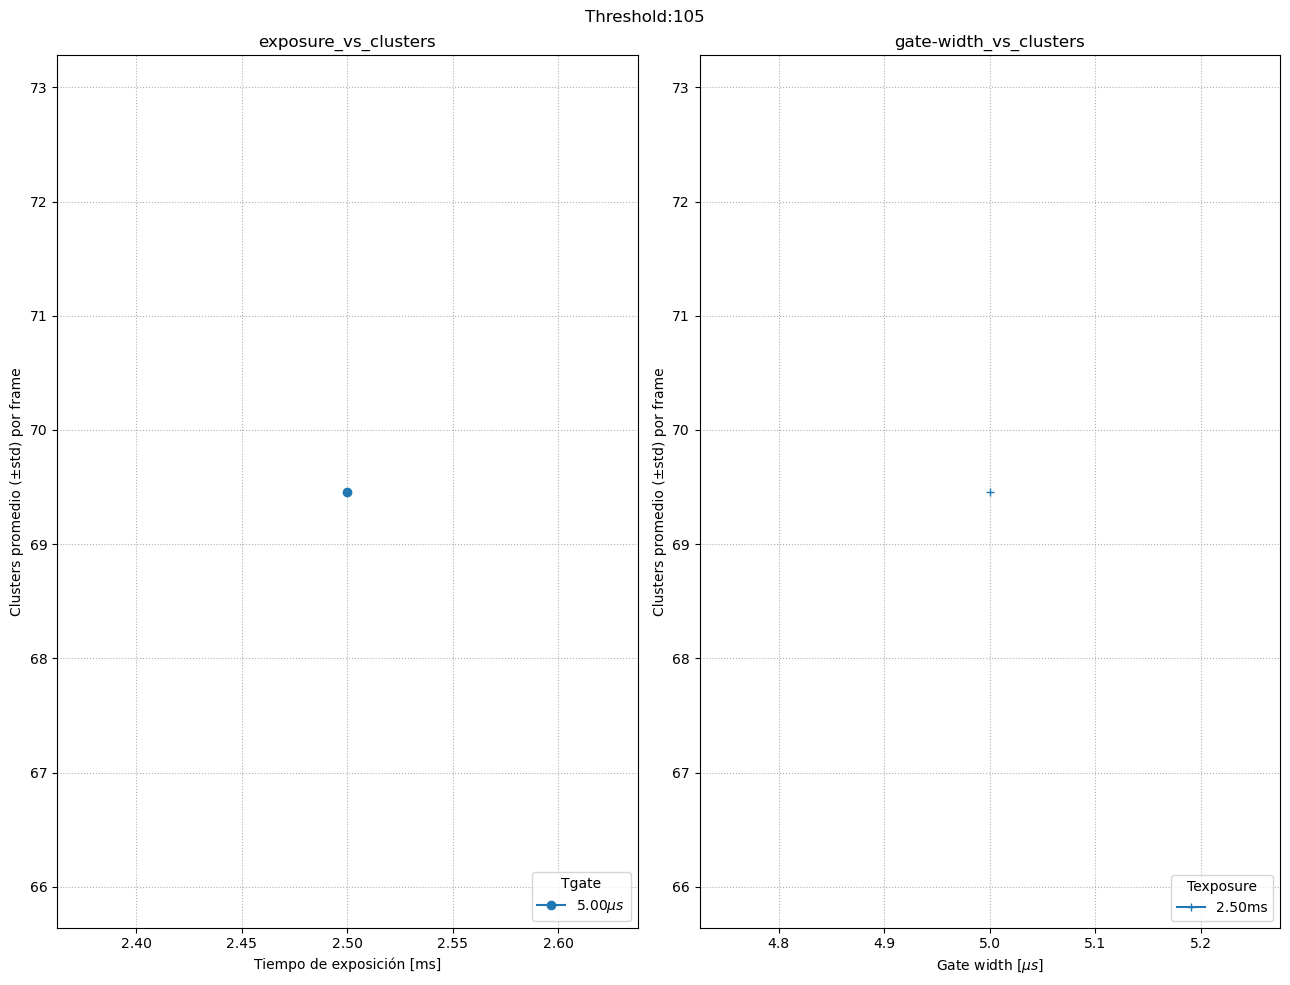

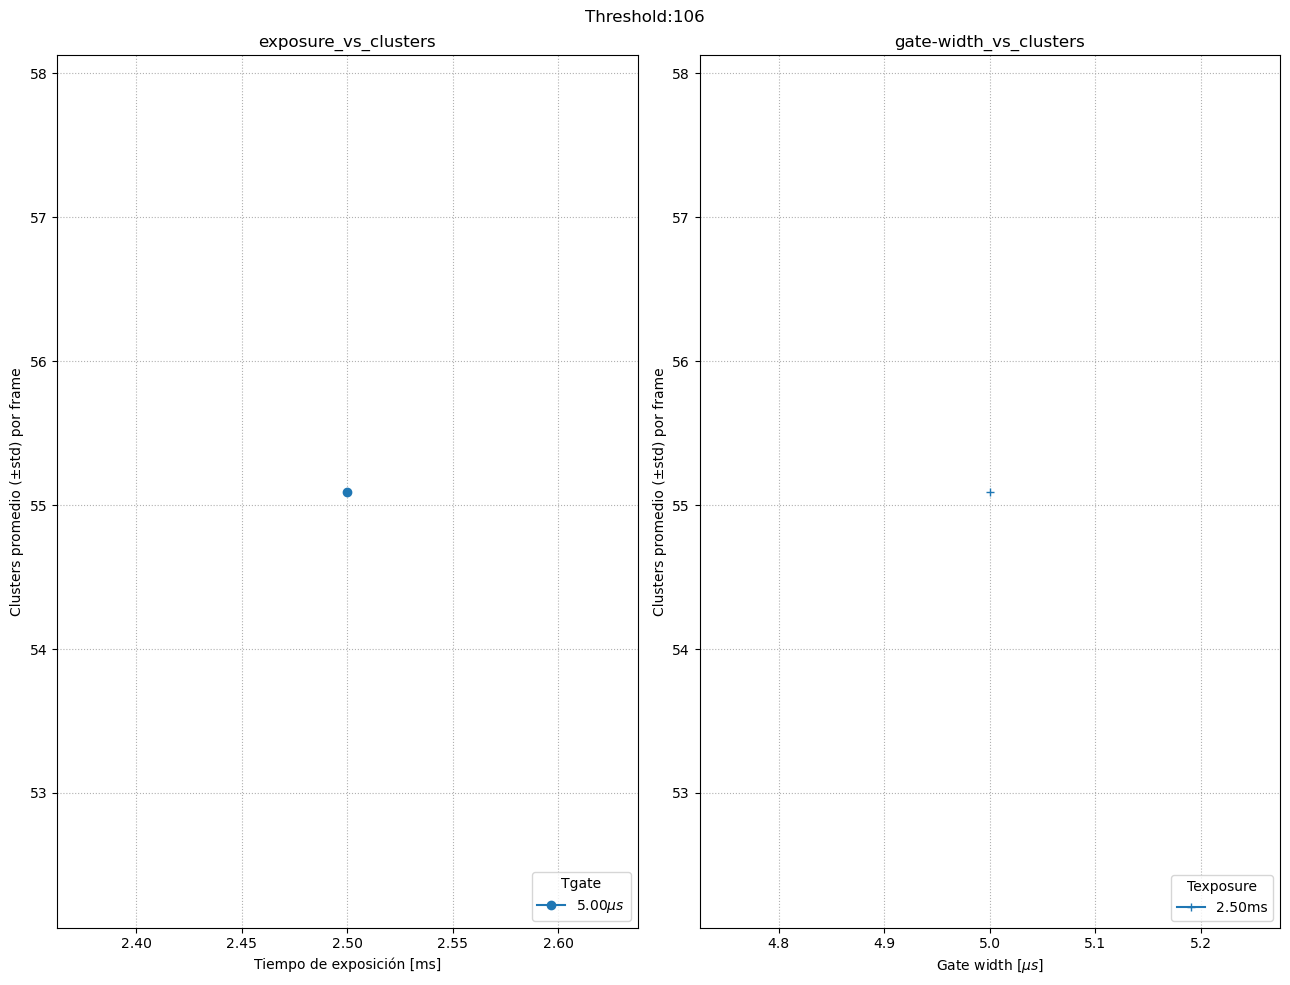

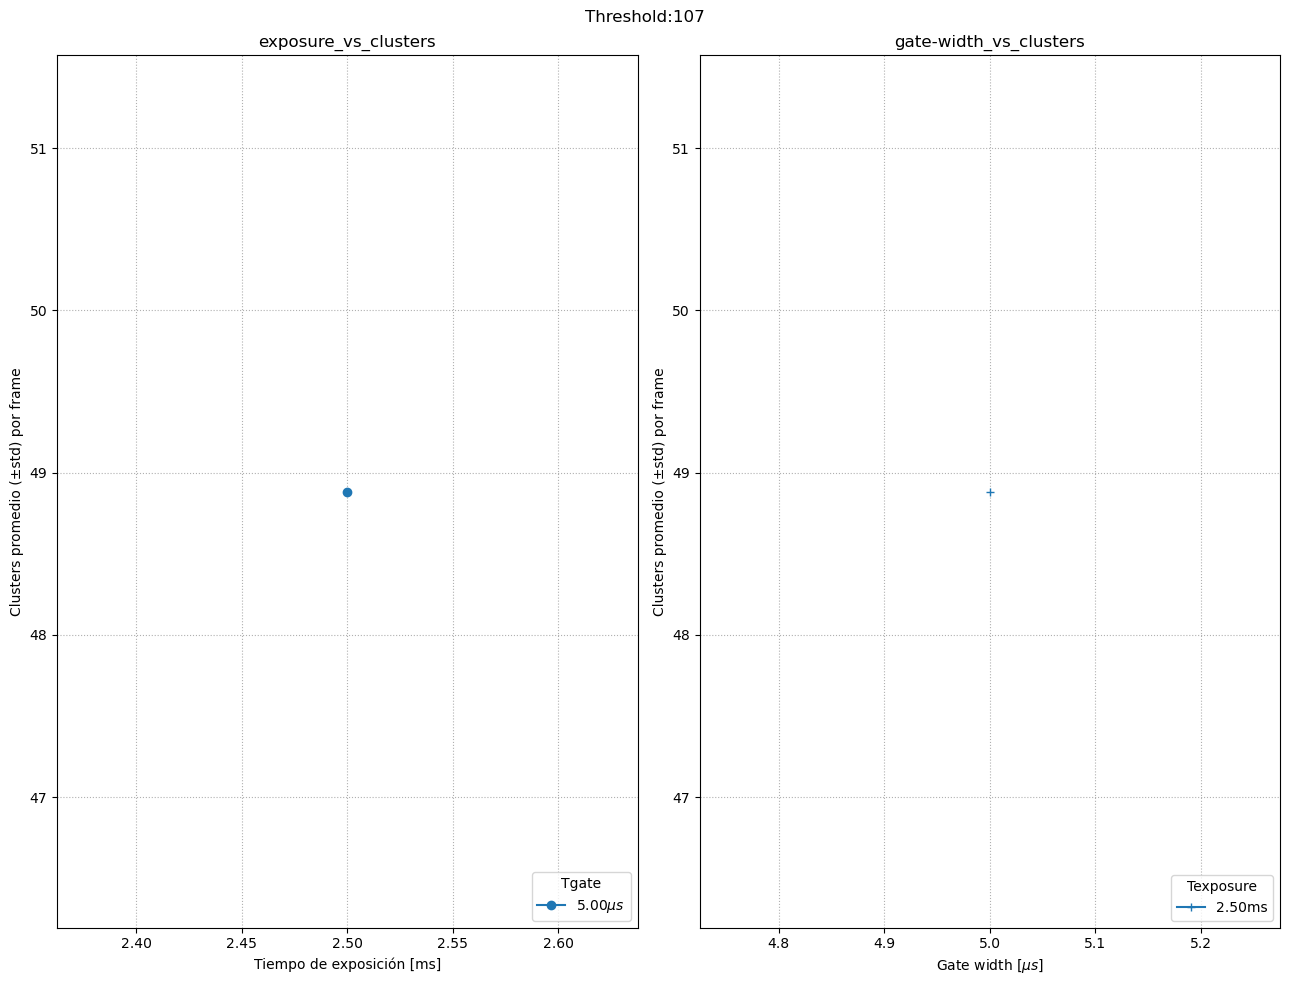

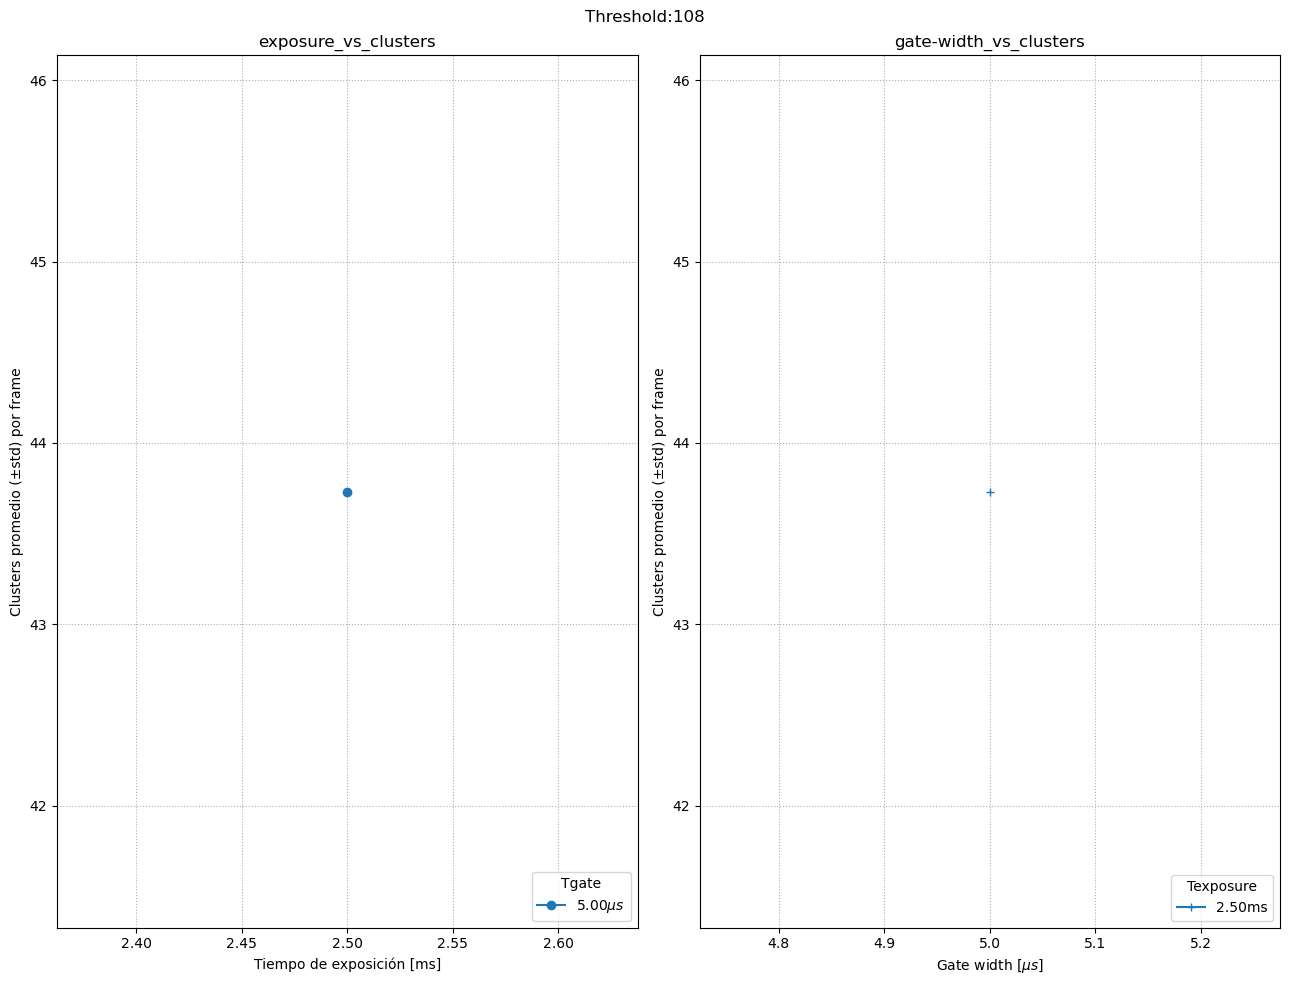

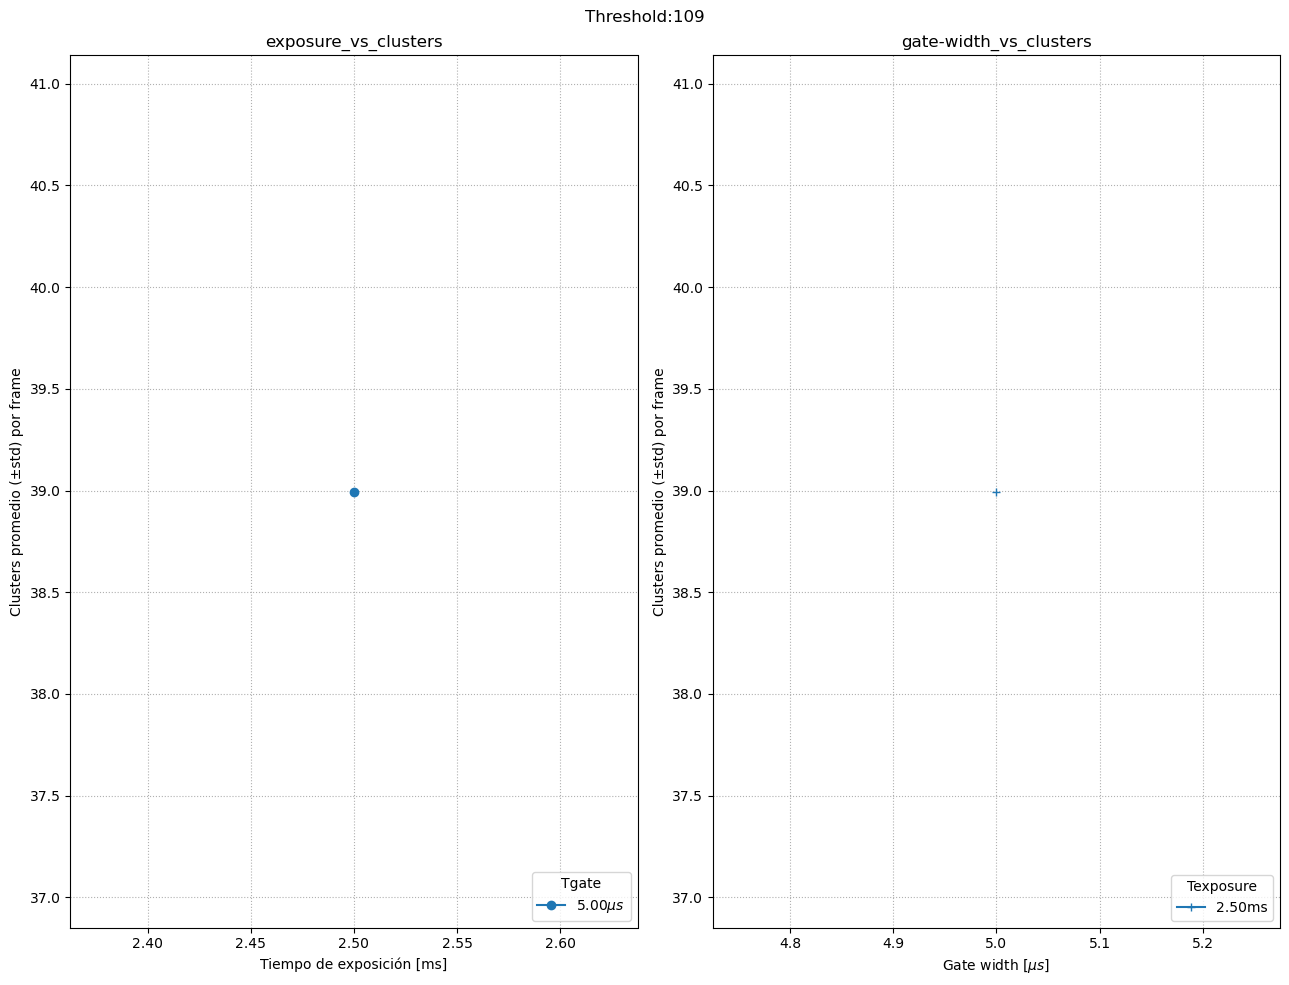

In [7]:

# {'file','gain','npics','texp_s','gate_width_s', 'date','threshold',
# 'n_frames','n_clusters_mean''n_clusters_std'}
for thresh in THRESHOLD:
    fig, axs = plt.subplots(nrows = 1,
                    ncols = 2,figsize= (13, 10),layout="constrained")
    fig.suptitle(f"Threshold:{thresh}")
    df = make_csv(CONNECTIVITY,thresh,out_csv = folder/"cluster_vs_exposure-time.csv")             # procesa y guarda
    plot_exposure_vs_clusters(df,thresh,axs[0])    # plotea exposure vs clusters 
    plot_gate_vs_clusters(df,thresh,axs[1])

    # plot_histograms(df, thresh, var="n_clusters_mean", group_var="gate_width_s")
    # plot_cluster_histograms(df,"gate_width_s","n_clusters_mean",threshold=thresh)

    # plot_histograms(df, thresh, var="n_clusters_mean", group_var="texp_s")
    # plot_cluster_histograms(df,"texp_s","n_clusters_mean",threshold=thresh)
    plt.tight_layout()

Procesando:   0%|                                                                                | 0/1 [00:00<?, ?it/s]

gain 4095  npics 1000  texp_s 0.0025  gate_width_s 5e-06


Procesando: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.91s/it]


CSV guardado en: C:\Users\orodrigov\Desktop\Photon counting\2025_11_06_03\cluster_vs_exposure-time.csv 



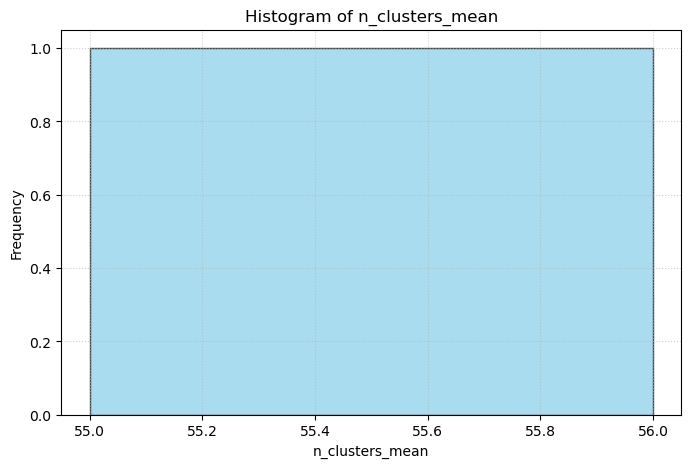

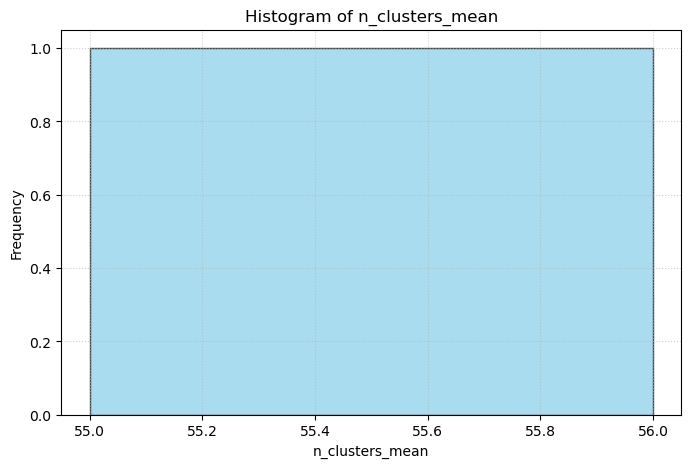

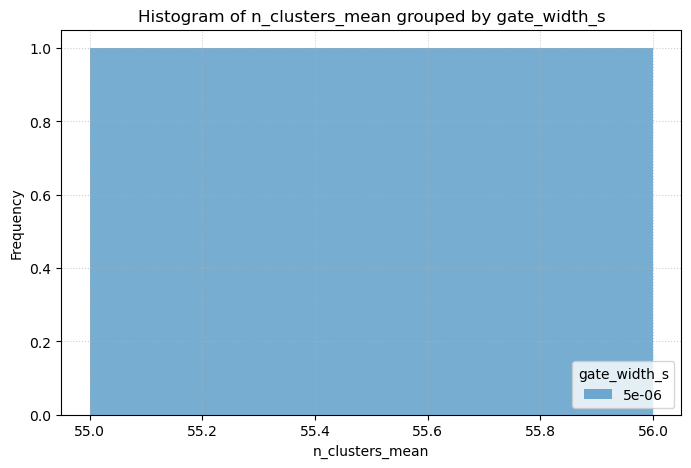

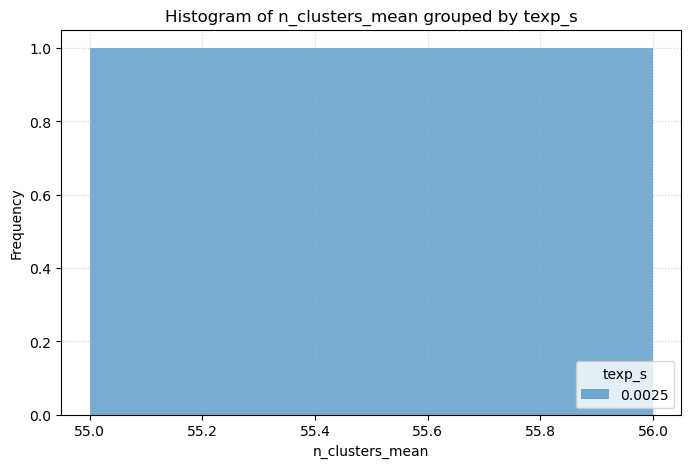

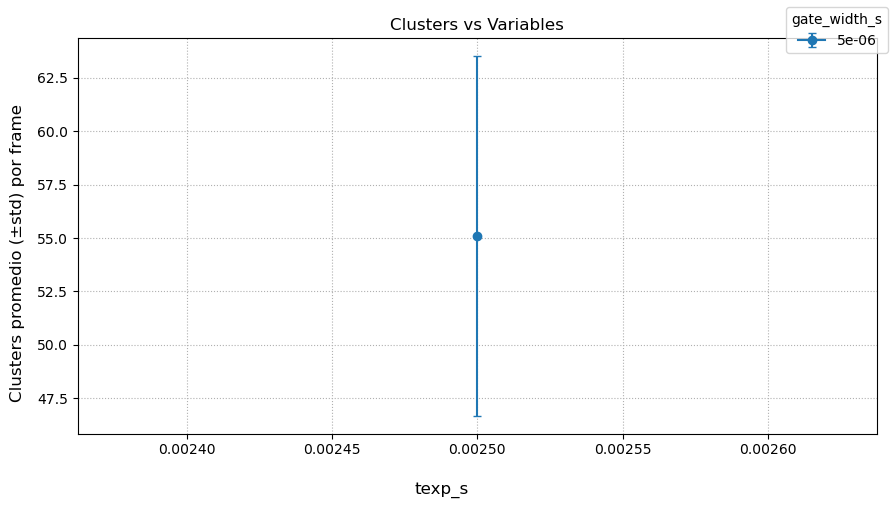

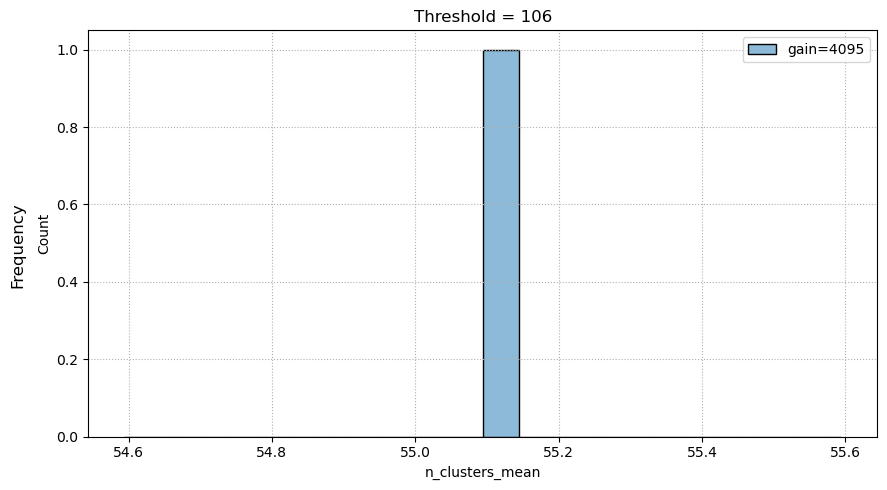

In [5]:
    threshold = 106
    df = make_csv(CONNECTIVITY,threshold,out_csv = folder/"cluster_vs_exposure-time.csv")
    plot_histograms(df, threshold, var="n_clusters_mean")
    plot_histograms(df, threshold, var="n_clusters_mean", group_var="")
    plot_histograms(df, threshold, var="n_clusters_mean", group_var="gate_width_s")
    plot_histograms(df, threshold, var="n_clusters_mean", group_var="texp_s")
    plot_clusters(df, group_var="gate_width_s", x_var="texp_s",y_var="n_clusters_mean")    
    # plot_clusters(df, group_var="texp_s", x_var="gate_width_s",y_var="n_clusters_mean",
    #               threshold=THRESHOLD)
    # plot_clusters(df, group_var="texp_s", x_var="gate_width_s",y_var="n_clusters_mean",
    #               subplot_var="gain",threshold=THRESHOLD)
    # plot_clusters(df, group_var="gain", x_var="texp_s",y_var="n_clusters_mean",
    #               subplot_var="gain",threshold=THRESHOLD)
    # plot_clusters(df, group_var="texp_s", x_var="gain",y_var="n_clusters_mean"
    #               ,threshold=THRESHOLD)
    
    #Abajo, probatinas con el Chat GPT. Me sigue pareciendo una mierda de herramienta.
    plot_cluster_histograms(df, group_var="gain", x_var="n_clusters_mean", threshold=threshold)
    # plot_cluster_histograms(df, group_var="texp_s", x_var="n_clusters_mean", subplot_var="gain", threshold=THRESHOLD)
    # plot_cluster_histograms(df, group_var="gate_width_s", x_var="n_clusters_mean", subplot_var="gain", threshold=THRESHOLD)

    # plot_histograms(df, var="n_clusters_mean")
    # plot_histograms(df, var="n_clusters_mean", group_var="gain")
    # plot_histograms(df, var="n_clusters_mean", group_var="gate_width_s")
    # plot_histograms(df, var="n_clusters_mean", group_var="texp_s")
    plt.show()
    plt.close("all")